In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding='same'),
            nn.SiLU()
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.SiLU()
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.SiLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.SiLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.SiLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.SiLU(),
        )
        self.conv_layer12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.SiLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512),
            nn.SiLU()
        )
        self.fc_layer2 = nn.Linear(512, n_classes)

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = self.conv_layer11(x)
        x = self.conv_layer12(x)
        x = self.flatten(x)
        x = self.fc_layer1(x)
        out = self.fc_layer2(x)

        return out

In [4]:
model = CNNModel(10)

model.to(device)
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
  )
  (conv_layer5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
  )
  (conv_layer6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): SiLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer7): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/50], Loss: 2.1864, Accuracy: 17.80%, Test Loss: 1.9563, Test Accuracy: 26.47%
Epoch [2/50], Loss: 1.7042, Accuracy: 35.83%, Test Loss: 1.6267, Test Accuracy: 40.45%
Epoch [3/50], Loss: 1.4465, Accuracy: 47.23%, Test Loss: 1.3226, Test Accuracy: 51.70%
Epoch [4/50], Loss: 1.1907, Accuracy: 57.18%, Test Loss: 1.0881, Test Accuracy: 61.27%
Epoch [5/50], Loss: 1.0182, Accuracy: 63.80%, Test Loss: 1.1136, Test Accuracy: 61.86%
Epoch [6/50], Loss: 0.9061, Accuracy: 68.04%, Test Loss: 0.9168, Test Accuracy: 68.19%
Epoch [7/50], Loss: 0.7818, Accuracy: 72.73%, Test Loss: 0.8323, Test Accuracy: 71.54%
Epoch [8/50], Loss: 0.6999, Accuracy: 75.51%, Test Loss: 0.8713, Test Accuracy: 70.64%
Epoch [9/50], Loss: 0.6139, Accuracy: 78.64%, Test Loss: 0.7921, Test Accuracy: 74.08%
Epoch [10/50], Loss: 0.5580, Accuracy: 80.44%, Test Loss: 0.8072, Test Accuracy: 73.48%
Epoch [11/50], Loss: 0.4791, Accuracy: 83.18%, Test Loss: 0.7846, Test Accuracy: 75.02%
Epoch [12/50], Loss: 0.4228, Accuracy: 85

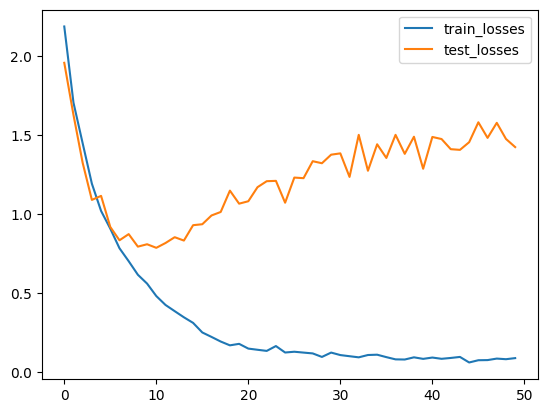

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

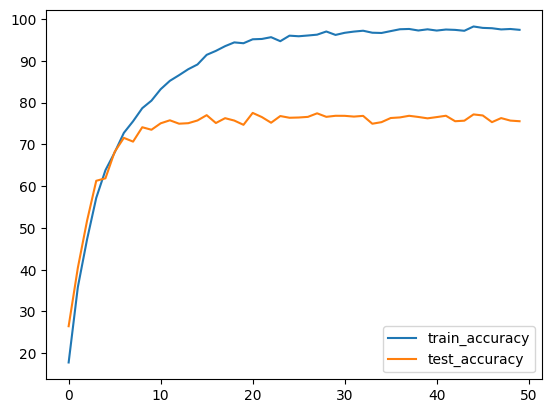

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()